In [1]:
import xarray as xr
import pandas as pd
import numpy as np

In [2]:
ds = xr.open_dataset('pnwrain.50km.daily.4994.nc', decode_times=False)

In [3]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 17 ;
	lon = 16 ;
	time = 16801 ;

variables:
	float32 lat(lat) ;
		lat:title = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:title = Longitude ;
		lon:units = degrees_east ;
	float64 time(time) ;
		time:title = Time ;
		time:units = days    since 1949- 1- 1  0: 0: 0 ;
	float32 data(time, lat, lon) ;
		data:long_name = mm/day ;
		data:units = mm/day ;

// global attributes:
}

### Manually decode time variable since it fails when opening dataset

the extra spaces of the attribute unit string of the time variable is causing this issue

In [4]:
print(ds['time'])

<xarray.DataArray 'time' (time: 16801)>
array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.6798e+04, 1.6799e+04,
       1.6800e+04])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 1.68e+04 1.68e+04 1.68e+04
Attributes:
    title:    Time
    units:    days    since 1949- 1- 1  0: 0: 0


In [5]:
time_values = ds.time.values

Extract time values and units

In [6]:
time_values = ds.time.values

# Empty spaces in the unit string will cause issue on num2date function
# time_units = ds.time.attrs['units']

In [7]:
# Manually Parse the units string instead
reference_date = '1949-01-01 00:00:00'
time_units = 'days since ' + reference_date

Decode time values (assume Gregorian calendar )

In [8]:
from cftime import num2date

time_index = num2date(time_values, units=time_units)

In [9]:
# Create a Dataset with the time_index variable
time_ds = xr.Dataset({'time_index': ('time', time_index)})

# Merge the time_ds Dataset with the original dataset
ds = xr.merge([ds, time_ds], combine_attrs='override')

In [10]:
# Set 'time_index' as the new coordinate for 'time'
ds = ds.assign_coords({'time': ds['time_index']})

In [11]:
ds = ds.drop_vars('time_index')

In [12]:
ds['time'].attrs = {
    'title': 'Time',
    'units': 'days since 1949-01-01 00:00:00'
}

In [13]:
# convert cftime.DatetimeGregorian to datetime
datetimeindex = ds.indexes['time'].to_datetimeindex()
ds['time'] = datetimeindex

In [14]:
# Set time as the index
ds = ds.set_index(time='time')

In [15]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 17 ;
	lon = 16 ;
	time = 16801 ;

variables:
	float32 lat(lat) ;
		lat:title = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:title = Longitude ;
		lon:units = degrees_east ;
	datetime64[ns] time(time) ;
	float32 data(time, lat, lon) ;
		data:long_name = mm/day ;
		data:units = mm/day ;

// global attributes:
}

Check gap in dates

In [16]:
# Calculate the differences between consecutive time points
time_diff = ds['time'].diff(dim='time')

# Convert time differences to a more interpretable format, like days
time_diff_in_days = time_diff / pd.to_timedelta(1, unit='D')

In [17]:
# more than 1 day is consider a gap
large_gap_threshold = 1  # days

# Find where the gaps exceed this threshold
large_gaps = time_diff_in_days.where(time_diff_in_days > large_gap_threshold, drop=True)

In [18]:
# Check if there are gaps
if len(large_gaps) > 0:
    print("Large gaps found at the following times:")
    print(large_gaps)
else:
    print("No large gaps found in the dates.")

No large gaps found in the dates.


Flatten data

In [19]:
# Stack 'lat' and 'lon' to create a single 'spatial' dimension
data_flat = ds['data'].stack(all_points=('time', 'lat', 'lon'))

In [20]:
data_flat

<xarray.DataArray 'data' (all_points: 4569872)>
array([nan, nan, nan, ..., 7.4, nan, nan], dtype=float32)
Coordinates:
  * all_points  (all_points) object MultiIndex
  * time        (all_points) datetime64[ns] 1949-01-01 1949-01-01 ... 1994-12-31
  * lat         (all_points) float32 49.76 49.76 49.76 ... 42.14 42.14 42.14
  * lon         (all_points) float32 -125.6 -125.0 -124.4 ... -116.9 -116.2
Attributes:
    long_name:  mm/day
    units:      mm/day

In [21]:
df_flat = data_flat.to_dataframe(name='precipitation').reset_index(drop=True)

In [22]:
print(df_flat.columns)

Index(['time', 'lat', 'lon', 'precipitation'], dtype='object')


In [23]:
df_flat.head(10)

,time,lat,lon,precipitation
0,1949-01-01,49.760941,-125.625,NaN
1,1949-01-01,49.760941,-125.000,NaN
2,1949-01-01,49.760941,-124.375,NaN
3,1949-01-01,49.760941,-123.750,NaN
4,1949-01-01,49.760941,-123.125,NaN
5,1949-01-01,49.760941,-122.500,NaN
6,1949-01-01,49.760941,-121.875,NaN
7,1949-01-01,49.760941,-121.250,NaN
8,1949-01-01,49.760941,-120.625,NaN
9,1949-01-01,49.760941,-120.000,NaN


Handle missing value in data

In [24]:
df_flat['precipitation'].fillna(0, inplace=True)

Check duplicated rows

In [25]:
# Check for any duplicate rows based on all columns
duplicate_rows = df_flat.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

# To see the actual duplicate rows
if duplicate_rows.sum() > 0:
    print(df_flat[duplicate_rows])

Number of duplicate rows: 0


Get ranges

In [26]:
min_date = df_flat['time'].min()
max_date = df_flat['time'].max()

print(f"The dataset covers from {min_date} to {max_date}.")

The dataset covers from 1949-01-01 00:00:00 to 1994-12-31 00:00:00.


In [27]:
# latitude
min_lat = df_flat['lat'].min()
max_lat = df_flat['lat'].max()

# longitude
min_lon = df_flat['lon'].min()
max_lon = df_flat['lon'].max()

print(f"The latitude range of the dataset is from {min_lat} to {max_lat}.")
print(f"The longitude range of the dataset is from {min_lon} to {max_lon}.")

The latitude range of the dataset is from 42.142059326171875 to 49.76094055175781.
The longitude range of the dataset is from -125.625 to -116.25.


## Features

In [28]:
df_flat['month'] = df_flat['time'].dt.month
df_flat['year'] = df_flat['time'].dt.year

Temporal Features

In [29]:
df_flat['day_of_year'] = df_flat['time'].dt.dayofyear
df_flat['week_of_year'] = df_flat['time'].dt.isocalendar().week
df_flat['day_of_week'] = df_flat['time'].dt.dayofweek

In [30]:
df_flat.size

41128848

In [31]:
df_flat.head(10)

,time,lat,lon,precipitation,month,year,day_of_year,week_of_year,day_of_week
0,1949-01-01,49.760941,-125.625,0.0,1,1949,1,53,5
1,1949-01-01,49.760941,-125.000,0.0,1,1949,1,53,5
2,1949-01-01,49.760941,-124.375,0.0,1,1949,1,53,5
3,1949-01-01,49.760941,-123.750,0.0,1,1949,1,53,5
4,1949-01-01,49.760941,-123.125,0.0,1,1949,1,53,5
5,1949-01-01,49.760941,-122.500,0.0,1,1949,1,53,5
6,1949-01-01,49.760941,-121.875,0.0,1,1949,1,53,5
7,1949-01-01,49.760941,-121.250,0.0,1,1949,1,53,5
8,1949-01-01,49.760941,-120.625,0.0,1,1949,1,53,5
9,1949-01-01,49.760941,-120.000,0.0,1,1949,1,53,5


In [32]:
# df_flat.to_csv('precipitation_data.csv', index=False)

In [33]:
grouped_by_area = df_flat.groupby(['lat', 'lon'])

Fliter out Non zero

In [34]:
len(df_flat)

4569872

In [35]:
non_zero_precipitation_count = df_flat[df_flat['precipitation'].notna() & (df_flat['precipitation'] != 0)].shape[0]

In [36]:
non_zero_precipitation_count

1329879

In [37]:
df_non_zero = df_flat[df_flat['precipitation'] > 0.0]

In [38]:
len(df_non_zero)

1329879

# Visualization

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

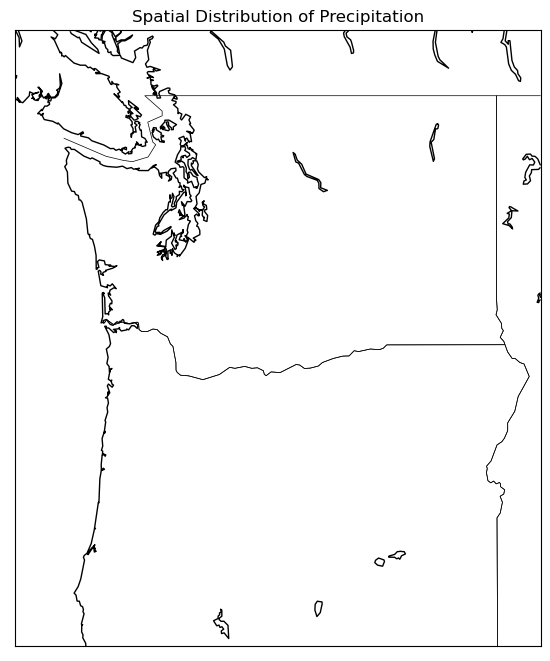

In [40]:
# Define the boundaries of the map and resolution
fig, ax = plt.subplots(figsize=(10, 8))
m = Basemap(projection='merc', llcrnrlat=df_flat['lat'].min(), urcrnrlat=df_flat['lat'].max(),
            llcrnrlon=df_flat['lon'].min(), urcrnrlon=df_flat['lon'].max(), resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Convert lat and lon to map projection coordinates
lons, lats = m(df_flat['lon'].values, df_flat['lat'].values)

plt.title('Spatial Distribution of Precipitation')
plt.show()

### Functions

In [41]:
def filter_data(df, min_lon, max_lon, min_lat, max_lat):
    """
    Filters the DataFrame for non-zero precipitation and within the specified bounds.

    Parameters:
    - df: pandas DataFrame containing the dataset
    - min_lon, max_lon: Minimum and maximum longitude of the bounding box
    - min_lat, max_lat: Minimum and maximum latitude of the bounding box

    Returns:
    - A pandas DataFrame filtered according to the specified parameters
    """
    filtered_df = df[(df['precipitation'] > 0) &
              (df['lon'] >= min_lon) & (df['lon'] <= max_lon) &
              (df['lat'] >= min_lat) & (df['lat'] <= max_lat)]

    return filtered_df.copy()

In [42]:
def filter_data_within_range(df, central_lat, central_lon, lat_range, lon_range):
    """
    Selects data within a specified range around a central latitude and longitude.

    Parameters:
    - df: pandas DataFrame to filter.
    - central_lat: Central latitude of the target area.
    - central_lon: Central longitude of the target area.
    - lat_range: Latitude range (extent) around the central latitude.
    - lon_range: Longitude range (extent) around the central longitude.

    Returns:
    - A pandas DataFrame containing only the data within the specified range.
    """
    min_lat = central_lat - lat_range / 2
    max_lat = central_lat + lat_range / 2
    min_lon = central_lon - lon_range / 2
    max_lon = central_lon + lon_range / 2

    filtered_df = df[(df['lat'] >= min_lat) & (df['lat'] <= max_lat) &
                     (df['lon'] >= min_lon) & (df['lon'] <= max_lon)]
    return filtered_df

In [43]:
central_lat = 47.0
central_lon = -122.0
lat_range = 3.0
lon_range = 3.0

selected_data = filter_data_within_range(df_non_zero, central_lat, central_lon, lat_range, lon_range)

In [44]:
print(f"Data points longitude range: {selected_data['lon'].min()} to {selected_data['lon'].max()}")
print(f"Data points latitude range: {selected_data['lat'].min()} to {selected_data['lat'].max()}")

Data points longitude range: -123.125 to -120.625
Data points latitude range: 45.951499938964844 to 48.332401275634766


In [45]:
def calculate_average_precipitation(df):
    """
    Groups the DataFrame by latitude and longitude and calculates the mean precipitation.

    Parameters:
    - df: pandas DataFrame with the filtered dataset

    Returns:
    - A pandas DataFrame with the mean precipitation for each group
    """
    return df.groupby(['lat', 'lon'])['precipitation'].mean().reset_index()

In [46]:
def plot_precipitation_heatmap(grouped_data, title, extent=None):
    """
    Creates a geospatial plot of the average precipitation data.

    Parameters:
    - grouped_data: pandas DataFrame with average precipitation data
    - title: Title for the plot
    - extent: Optional. A tuple of (min_lon, max_lon, min_lat, max_lat) for the map extent.
              If None, the extent is determined automatically.
    """
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    size_factor = 20
    point_sizes = grouped_data['precipitation'] * size_factor

    if not grouped_data.empty:
        sc = ax.scatter(grouped_data['lon'], grouped_data['lat'], c=grouped_data['precipitation'],
                        cmap='cool', s=point_sizes, edgecolor='black', linewidth=1,
                        transform=ccrs.PlateCarree())
        plt.colorbar(sc, label='Average Precipitation (mm/day)')
    else:
        print("No data available to plot.")

    print(f"Data points longitude range: {grouped_data['lon'].min()} to {grouped_data['lon'].max()}")
    print(f"Data points latitude range: {grouped_data['lat'].min()} to {grouped_data['lat'].max()}")

    if extent:
        print(f"Setting extent to: {extent}")
        # Set the extent using the set_extent method
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        # ax.set_xlim(extent[0], extent[1])
        # ax.set_ylim(extent[2], extent[3])
    else:
        print("Auto-adjusting extent based on data.")

    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.title(title)
    plt.show()

Data points longitude range: -124.375 to -116.25
Data points latitude range: 42.142059326171875 to 48.80857849121094
Auto-adjusting extent based on data.


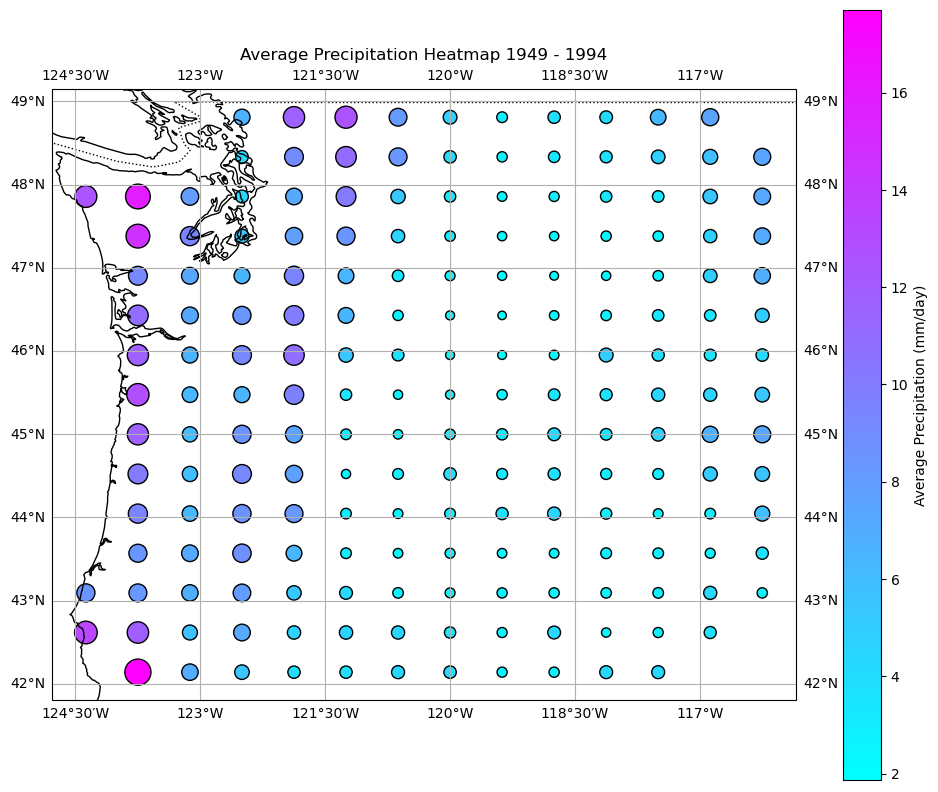

In [47]:
# Group by latitude and longitude to calculate the mean precipitation
grouped_data = calculate_average_precipitation(df_non_zero)

plot_title = 'Average Precipitation Heatmap 1949 - 1994'
plot_precipitation_heatmap(grouped_data, plot_title)

In [48]:
# The bounds of the area to zoom into
min_lon, max_lon = -123, -121
min_lat, max_lat = 46, 48

In [49]:
# Filter data within the specified area.
filtered_df = filter_data(df_non_zero, min_lon, max_lon, min_lat, max_lat)

# Calculate the average precipitation
average_precip = calculate_average_precipitation(filtered_df)

Data points longitude range: -122.5 to -121.25
Data points latitude range: 46.42768096923828 to 47.85622024536133
Setting extent to: (-123, -121, 46, 48)


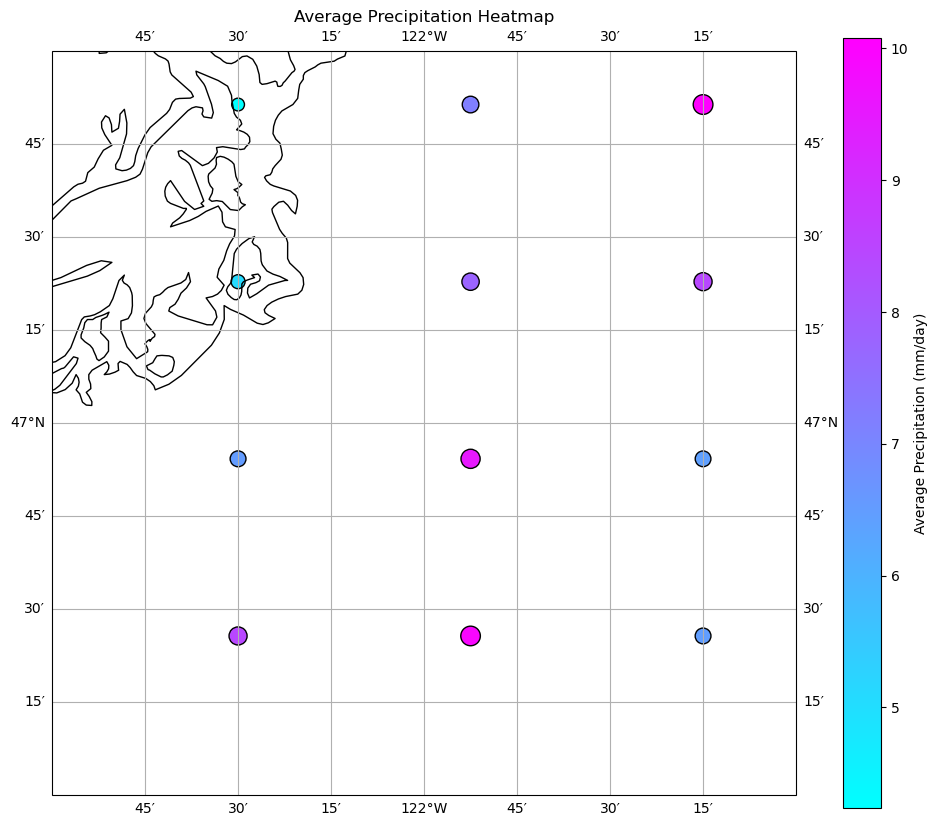

In [50]:
# Plot the results with a specified extent
plot_title = 'Average Precipitation Heatmap'
plot_precipitation_heatmap(average_precip, plot_title, extent=(min_lon, max_lon, min_lat, max_lat))

In [51]:
# df_filtered = df_non_zero

# # Group by latitude and longitude to calculate the mean precipitation
# grouped = df_filtered.groupby(['lat', 'lon'])['precipitation'].mean().reset_index()

# # Create a figure with an projection
# fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# if not grouped.empty:
#     # Scatter plot for average precipitation
#     sc = ax.scatter(grouped['lon'], grouped['lat'], c=grouped['precipitation'],
#                     cmap='cool', s=150, edgecolor='black', linewidth=1,
#                     transform=ccrs.PlateCarree())  # Ensure the transform is correct
#     plt.colorbar(sc, label='Average Precipitation (mm/day)')
# else:
#     print("No non-zero precipitation data available to plot.")

# # Set the geographic extent to encompass all points or focus on a particular region
# # ax.set_extent([min longitude, max longitude, min latitude, max latitude], crs=ccrs.PlateCarree())
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# plt.title('Average Precipitation Heatmap 1949 - 1994')
# plt.show()

Plot specific area

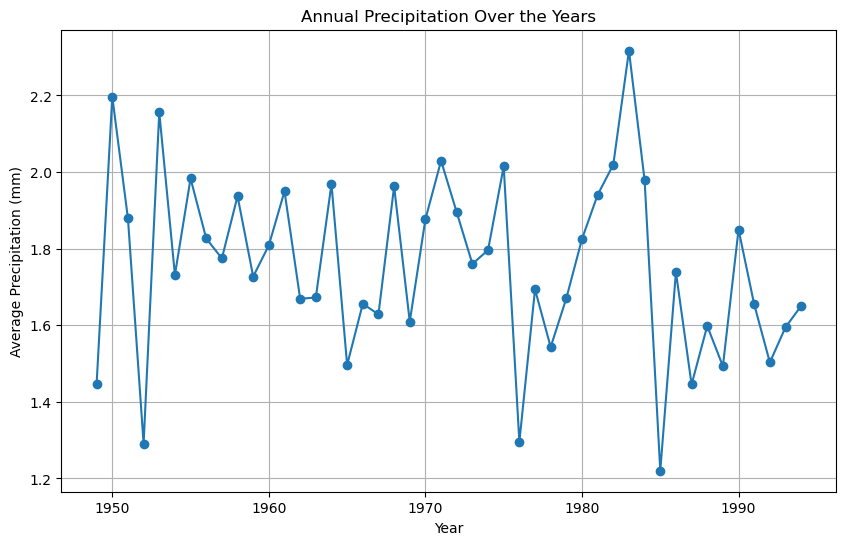

In [52]:
average_precipitation_df = df_flat.groupby('year')['precipitation'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(average_precipitation_df['year'], average_precipitation_df['precipitation'], marker='o', linestyle='-')
plt.title('Annual Precipitation Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm)')
plt.grid(True)
plt.show()

In [53]:
central_lat = 46.0
central_lon = -123.0
lat_range = 1.0
lon_range = 1.0

selected_data = filter_data_within_range(df_flat, central_lat, central_lon, lat_range, lon_range)

In [54]:
selected_data

,time,lat,lon,precipitation,month,year,day_of_year,week_of_year,day_of_week
116,1949-01-01,46.427681,-123.125,4.600000,1,1949,1,53,5
117,1949-01-01,46.427681,-122.500,20.200001,1,1949,1,53,5
132,1949-01-01,45.951500,-123.125,20.600000,1,1949,1,53,5
133,1949-01-01,45.951500,-122.500,18.200001,1,1949,1,53,5
388,1949-01-02,46.427681,-123.125,3.300000,1,1949,2,53,6
...,...,...,...,...,...,...,...,...,...
4569461,1994-12-30,45.951500,-122.500,0.000000,12,1994,364,52,4
4569716,1994-12-31,46.427681,-123.125,0.000000,12,1994,365,52,5
4569717,1994-12-31,46.427681,-122.500,0.000000,12,1994,365,52,5
4569732,1994-12-31,45.951500,-123.125,0.000000,12,1994,365,52,5


In [55]:
# Group by year and calculate average precipitation
average_precipitation_per_year = selected_data.groupby('year')['precipitation'].mean().reset_index()

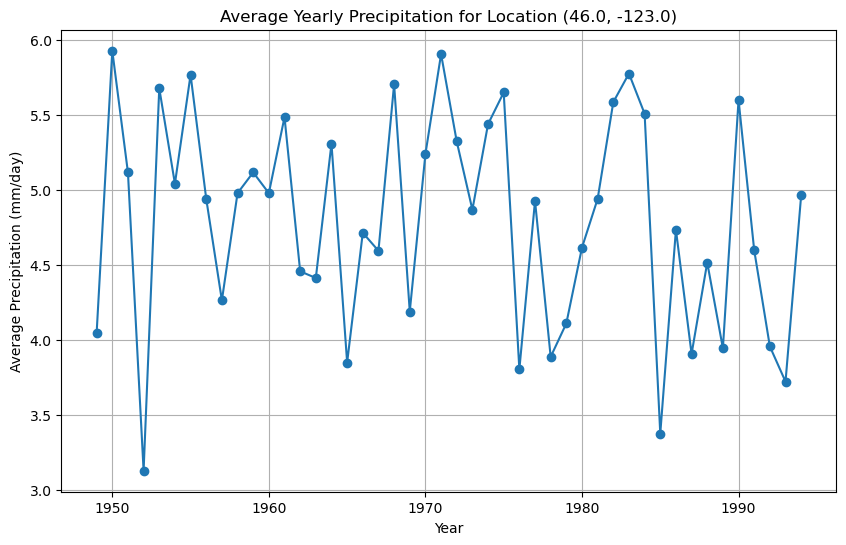

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(average_precipitation_per_year['year'], average_precipitation_per_year['precipitation'], marker='o')
plt.title(f"Average Yearly Precipitation for Location ({central_lat}, {central_lon})")
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm/day)')
plt.grid(True)
plt.show()

 zoom into the specific geographic zone

In [57]:
# Define the bounds of the area to zoom into
min_lon, max_lon = -117, -0
min_lat, max_lat = 43, 44

df_to_fliter = df_flat
# Filter the data for the specified zone
zone_data = df_to_fliter[(df_to_fliter['lon'] >= min_lon) & (df_to_fliter['lon'] <= max_lon) &
               (df_to_fliter['lat'] >= min_lat) & (df_to_fliter['lat'] <= max_lat)]

In [58]:
annual_precip = zone_data.groupby('year')['precipitation'].mean().reset_index()

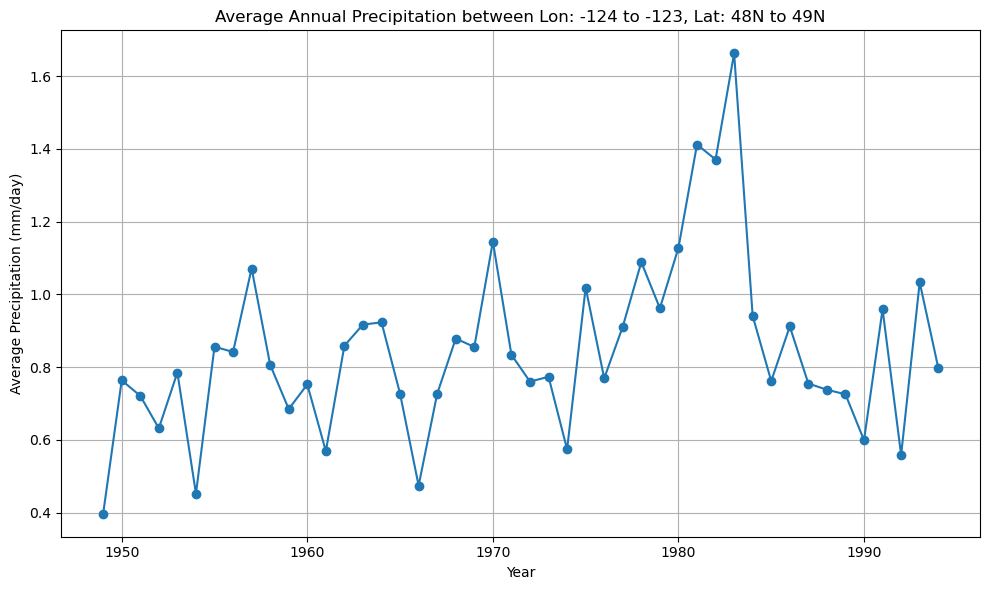

In [59]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(annual_precip['year'], annual_precip['precipitation'], marker='o')
plt.title('Average Annual Precipitation between Lon: -124 to -123, Lat: 48N to 49N')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm/day)')
plt.grid(True)
plt.tight_layout()
plt.show()

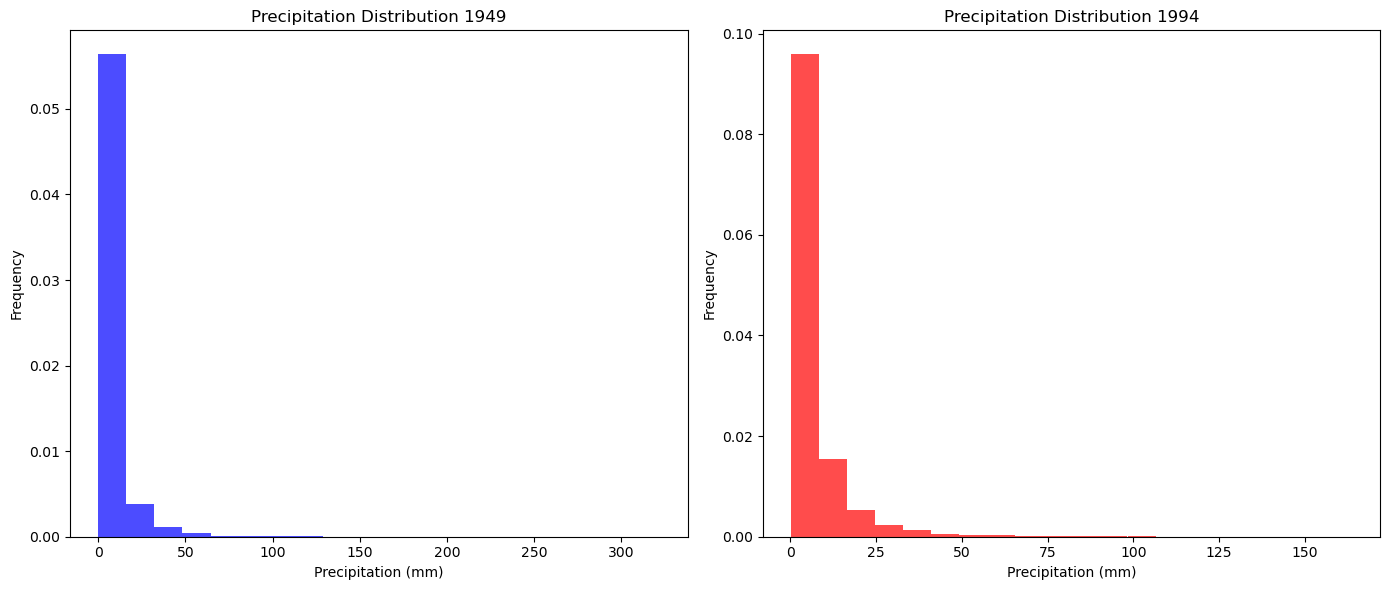

In [60]:
data_year1 = df_non_zero[df_non_zero['year'] == 1949]['precipitation']
data_year2 = df_non_zero[df_non_zero['year'] == 1994]['precipitation']

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].hist(data_year1, bins=20, density=True, color='blue', alpha=0.7)
ax[0].set_title('Precipitation Distribution 1949')
ax[0].set_xlabel('Precipitation (mm)')
ax[0].set_ylabel('Frequency')

ax[1].hist(data_year2, bins=20, density=True, color='red', alpha=0.7)
ax[1].set_title('Precipitation Distribution 1994')
ax[1].set_xlabel('Precipitation (mm)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

 Boxplots for Comparing Precipitation Across Different Years or Locations

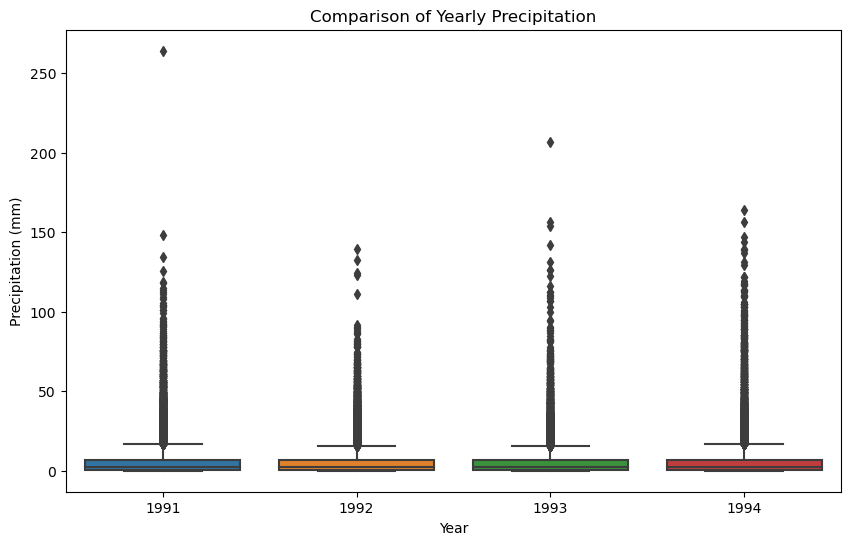

In [61]:
import seaborn as sns

# Prepare data for multiple years or locations
boxplot_data = df_non_zero[df_non_zero['year'].isin([1991, 1992, 1993, 1994])]

plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='precipitation', data=boxplot_data)
plt.title('Comparison of Yearly Precipitation')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.show()

In [62]:
df_flat

,time,lat,lon,precipitation,month,year,day_of_year,week_of_year,day_of_week
0,1949-01-01,49.760941,-125.625,0.000000,1,1949,1,53,5
1,1949-01-01,49.760941,-125.000,0.000000,1,1949,1,53,5
2,1949-01-01,49.760941,-124.375,0.000000,1,1949,1,53,5
3,1949-01-01,49.760941,-123.750,0.000000,1,1949,1,53,5
4,1949-01-01,49.760941,-123.125,0.000000,1,1949,1,53,5
...,...,...,...,...,...,...,...,...,...
4569867,1994-12-31,42.142059,-118.750,23.900000,12,1994,365,52,5
4569868,1994-12-31,42.142059,-118.125,25.800001,12,1994,365,52,5
4569869,1994-12-31,42.142059,-117.500,7.400000,12,1994,365,52,5
4569870,1994-12-31,42.142059,-116.875,0.000000,12,1994,365,52,5


In [63]:
df_time_series = df_flat.copy()

In [64]:
df_time_series['precipitation'] = df_time_series['precipitation'].fillna(0)

In [65]:
df_time_series.set_index(['time', 'lat', 'lon'], inplace=True)

In [66]:
df_time_series

precipitation  month  year  day_of_year  \
time       lat       lon                                                 
1949-01-01 49.760941 -125.625       0.000000      1  1949            1   
                     -125.000       0.000000      1  1949            1   
                     -124.375       0.000000      1  1949            1   
                     -123.750       0.000000      1  1949            1   
                     -123.125       0.000000      1  1949            1   
...                                      ...    ...   ...          ...   
1994-12-31 42.142059 -118.750      23.900000     12  1994          365   
                     -118.125      25.800001     12  1994          365   
                     -117.500       7.400000     12  1994          365   
                     -116.875       0.000000     12  1994          365   
                     -116.250       0.000000     12  1994          365   

                               week_of_year  day_of_week  
time       lat       lon                                  
1949-01-01 49.760941 -125.625            53            5  
                     -125.000            53            5  
                     -124.375            53            5  
                     -123.750            53            5  
                     -123.125            53            5  
...                                     ...          ...  
1994-12-31 42.142059 -118.750            52            5  
                     -118.125            52            5  
                     -117.500            52            5  
                     -116.875            52            5  
                     -116.250            52            5  

[4569872 rows x 6 columns]

In [67]:
from sklearn.cluster import KMeans

In [68]:
selected_data

,time,lat,lon,precipitation,month,year,day_of_year,week_of_year,day_of_week
116,1949-01-01,46.427681,-123.125,4.600000,1,1949,1,53,5
117,1949-01-01,46.427681,-122.500,20.200001,1,1949,1,53,5
132,1949-01-01,45.951500,-123.125,20.600000,1,1949,1,53,5
133,1949-01-01,45.951500,-122.500,18.200001,1,1949,1,53,5
388,1949-01-02,46.427681,-123.125,3.300000,1,1949,2,53,6
...,...,...,...,...,...,...,...,...,...
4569461,1994-12-30,45.951500,-122.500,0.000000,12,1994,364,52,4
4569716,1994-12-31,46.427681,-123.125,0.000000,12,1994,365,52,5
4569717,1994-12-31,46.427681,-122.500,0.000000,12,1994,365,52,5
4569732,1994-12-31,45.951500,-123.125,0.000000,12,1994,365,52,5


In [69]:
central_lat = 47.0
central_lon = -122.0
lat_range = 2.0
lon_range = 2.0

selected_data = filter_data_within_range(df_non_zero, central_lat, central_lon, lat_range, lon_range)

In [70]:
print(f"Data points longitude range: {selected_data['lon'].min()} to {selected_data['lon'].max()}")
print(f"Data points latitude range: {selected_data['lat'].min()} to {selected_data['lat'].max()}")

Data points longitude range: -122.5 to -121.25
Data points latitude range: 46.42768096923828 to 47.85622024536133


In [71]:
import os
# os.environ["OMP_NUM_THREADS"] = "4"
# os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
# os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
# os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
# os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn

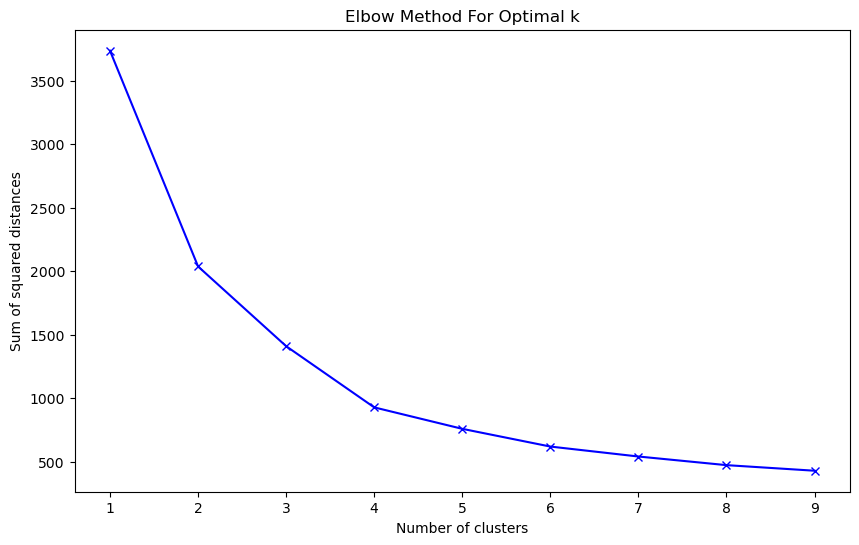

In [72]:
# Calculate the sum of squared distances (SSD) for a range of number of clusters
ssd = []
coords = df_flat[['lat', 'lon']].drop_duplicates().values
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init='auto' ,random_state=42)
    kmeans.fit(coords)
    ssd.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [73]:
coords = df_flat[['lat', 'lon']].drop_duplicates().values
unique_coords_df = pd.DataFrame(coords, columns=['lat', 'lon'])

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, n_init='auto', random_state=42)

cluster_labels = kmeans.fit_predict(unique_coords_df)

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [74]:
unique_coords_df['location_cluster'] = cluster_labels

In [75]:
df_flat = df_flat.merge(unique_coords_df, on=['lat', 'lon'], how='left')

In [76]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import MultiPoint

def plot_precipitation_heatmap_with_clusters(df_clusters, title, extent=None):
    """
    Creates a geospatial plot of the average precipitation data with extended cluster boundaries.

    Parameters:
    - df_clusters: pandas DataFrame with time-indexed precipitation data for each location cluster
    - title: Title for the plot
    - extent: Optional. A tuple of (min_lon, max_lon, min_lat, max_lat) for the map extent.
              If None, the extent is determined automatically.
    """
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Group by 'location_cluster', 'lat', and 'lon', and calculate mean precipitation
    grouped_data = df_clusters.groupby(['location_cluster', 'lat', 'lon'])['precipitation'].mean().reset_index()

    size_factor = 20
    point_sizes = grouped_data['precipitation'] * size_factor

    if not grouped_data.empty:
        sc = ax.scatter(grouped_data['lon'], grouped_data['lat'], c=grouped_data['precipitation'],
                        cmap='cool', s=point_sizes, edgecolor='black', linewidth=1,
                        transform=ccrs.PlateCarree())
        plt.colorbar(sc, label='Average Precipitation (mm/day)')

        # Calculate cluster boundaries
        clusters = []
        for cluster_label, cluster_group in grouped_data.groupby('location_cluster'):
            cluster_lon = cluster_group['lon']
            cluster_lat = cluster_group['lat']
            cluster_points = MultiPoint(list(zip(cluster_lon, cluster_lat)))
            cluster_boundary = cluster_points.convex_hull
            clusters.append((cluster_label, cluster_boundary))

        # Plot cluster boundaries
        for cluster_label, cluster_boundary in clusters:
            if cluster_boundary.geom_type == 'Polygon':
                extended_boundary = cluster_boundary.buffer(0.1)
                coords = np.array(extended_boundary.exterior.coords)
                ax.plot(coords[:, 0], coords[:, 1], label=f'Cluster {cluster_label}', linewidth=2)

        ax.legend()
    else:
        print("No data available to plot.")

    if extent:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    else:
        print("Auto-adjusting extent based on data.")

    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.title(title)
    plt.show()

Auto-adjusting extent based on data.


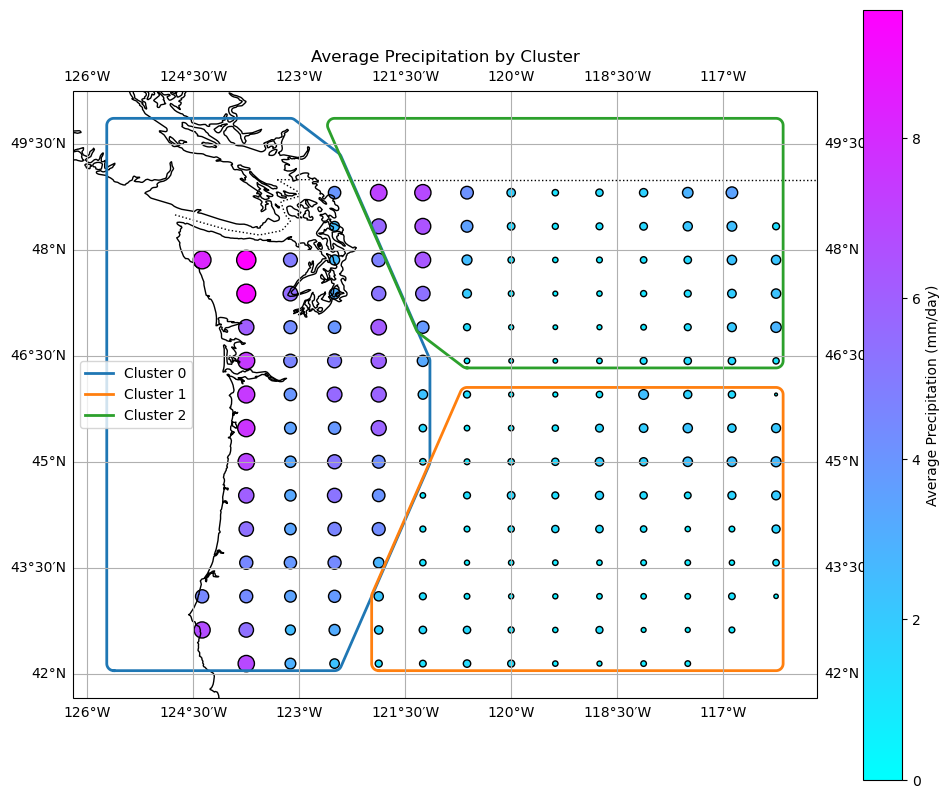

In [77]:
df_clusters = df_flat[['lat','lon','precipitation', 'location_cluster']]

df_clusters = df_clusters.reset_index(drop=True)
plot_precipitation_heatmap_with_clusters(df_clusters, 'Average Precipitation by Cluster')

In [78]:
def plot_precipitation_changes(df_clusters, cluster_label, start_year, end_year):
    """
    Plots the changes in precipitation for a specific cluster over consecutive periods.

    Parameters:
    - df_clusters: pandas DataFrame with time-indexed precipitation data for each location cluster
    - cluster_label: The label of the cluster to plot
    - start_year: The starting year for the first period
    - end_year: The ending year for the last period
    """

    interval = end_year - start_year

    cluster_data = df_clusters[df_clusters['location_cluster'] == cluster_label]

    # Filter data for the specified years
    period_data = cluster_data[(cluster_data['year'] >= start_year) & (cluster_data['year'] <= end_year)]

    # Group by year and calculate mean precipitation
    grouped_data = period_data.groupby('year')['precipitation'].mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(grouped_data.index, grouped_data.values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Average Precipitation (mm/day)')
    plt.title(f'Changes in Precipitation for Cluster {cluster_label} over Consecutive {interval}-Year Periods')
    plt.grid(True)
    plt.xticks(grouped_data.index)
    plt.show()


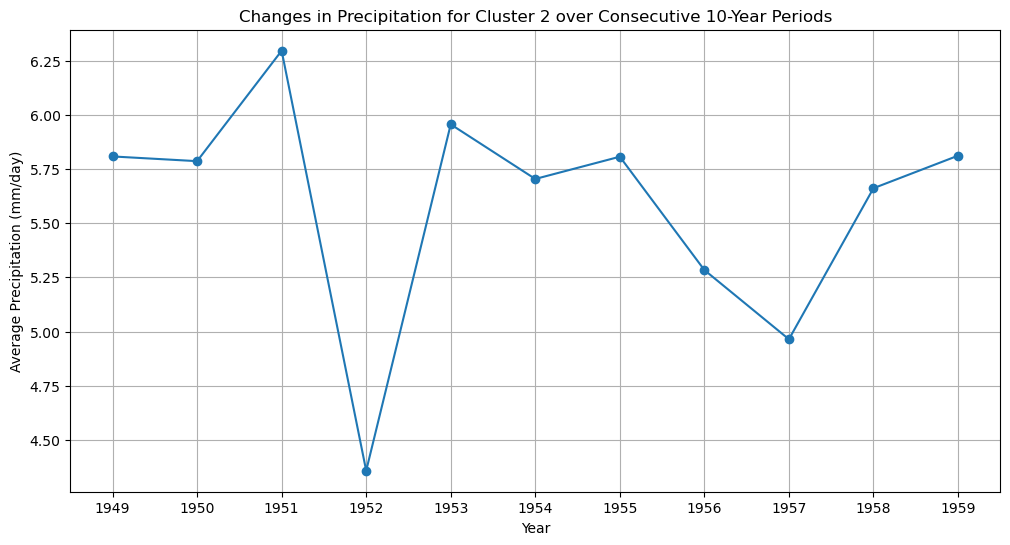

In [79]:
df_clusters = df_flat[['lat','lon','precipitation', 'location_cluster', 'year']]

df_clusters = df_clusters.reset_index(drop=True)

df_clusters_nonzero = df_clusters[df_clusters['precipitation'] > 0]

plot_precipitation_changes(df_clusters_nonzero, 2, 1949, 1959)

In [80]:
df_clusters.set_index('year')

,lat,lon,precipitation,location_cluster
year,,,,
1949,49.760941,-125.625,0.000000,0
1949,49.760941,-125.000,0.000000,0
1949,49.760941,-124.375,0.000000,0
1949,49.760941,-123.750,0.000000,0
1949,49.760941,-123.125,0.000000,0
...,...,...,...,...
1994,42.142059,-118.750,23.900000,1
1994,42.142059,-118.125,25.800001,1
1994,42.142059,-117.500,7.400000,1


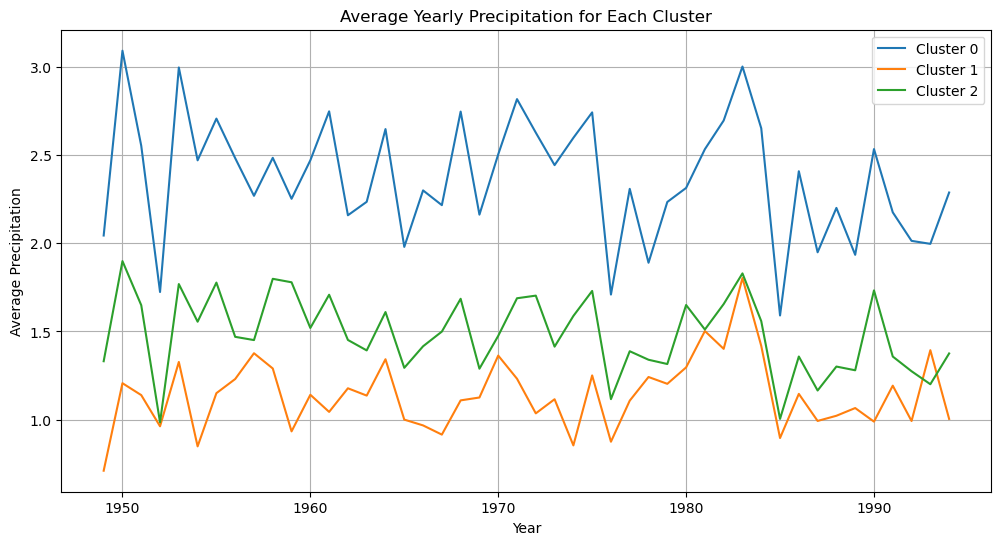

In [81]:
yearly_avg_precipitation = df_clusters.groupby(['location_cluster', 'year'])['precipitation'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
for cluster_label, cluster_data in yearly_avg_precipitation.groupby('location_cluster'):
    plt.plot(cluster_data['year'], cluster_data['precipitation'], label=f'Cluster {cluster_label}')

plt.title('Average Yearly Precipitation for Each Cluster')
plt.xlabel('Year')
plt.ylabel('Average Precipitation')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
yearly_avg_precipitation

,location_cluster,year,precipitation
0,0,1949,2.043605
1,0,1950,3.090814
2,0,1951,2.551836
3,0,1952,1.723564
4,0,1953,2.995922
...,...,...,...
133,2,1990,1.732693
134,2,1991,1.357898
135,2,1992,1.274605
136,2,1993,1.200991


### Additive Decomposition

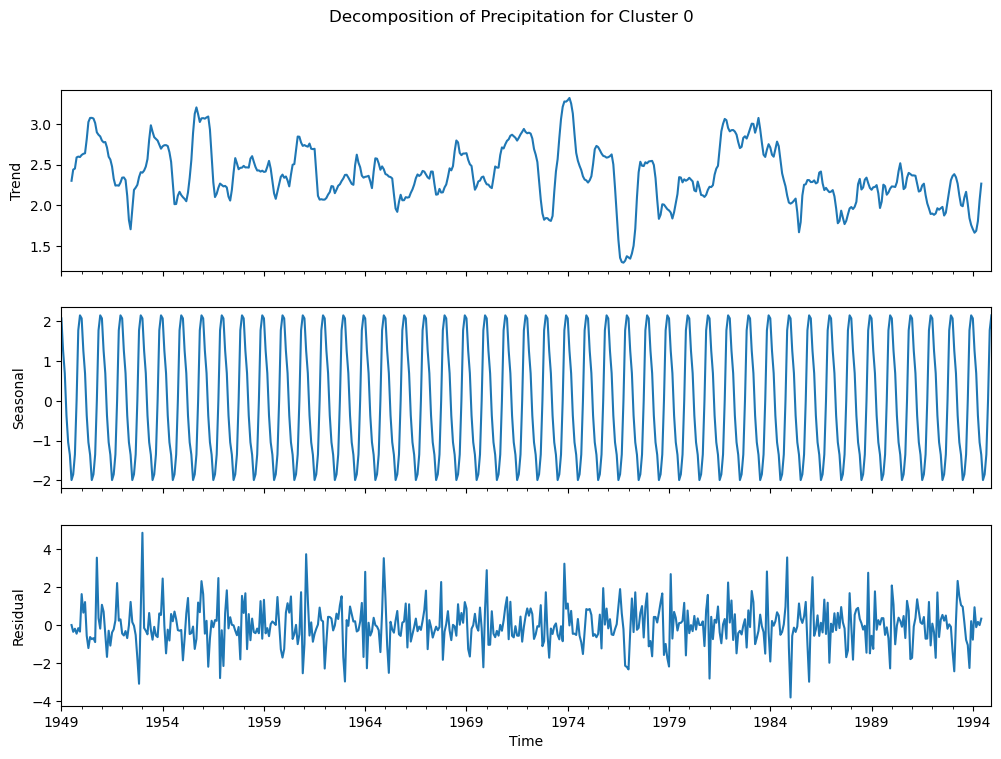

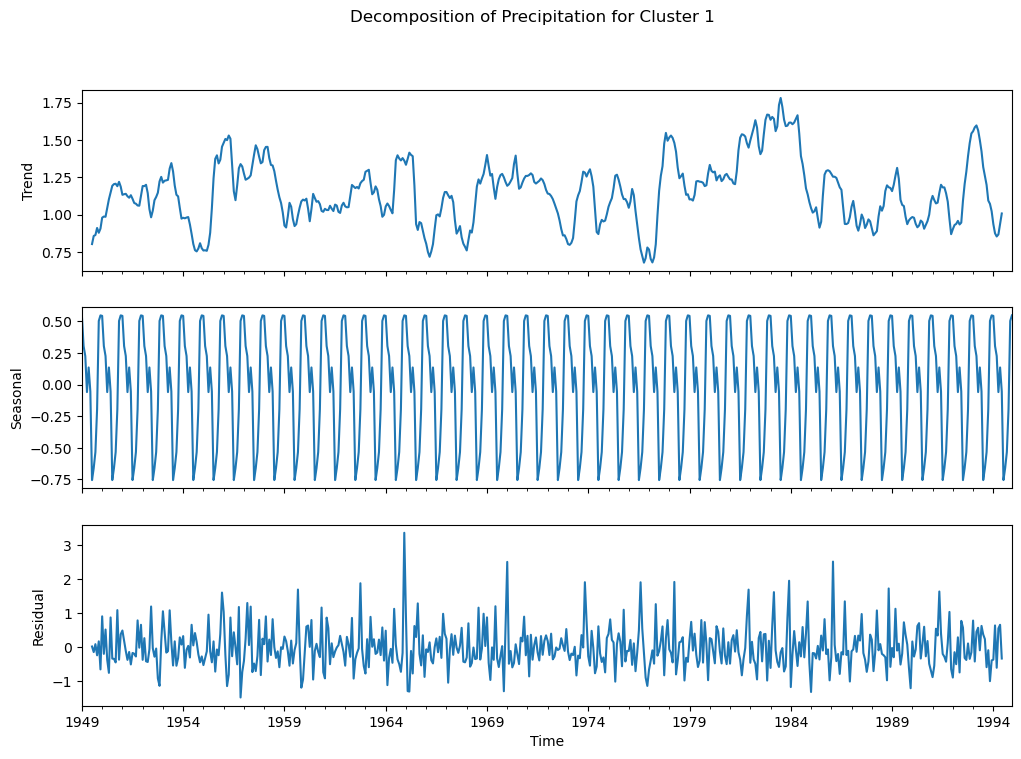

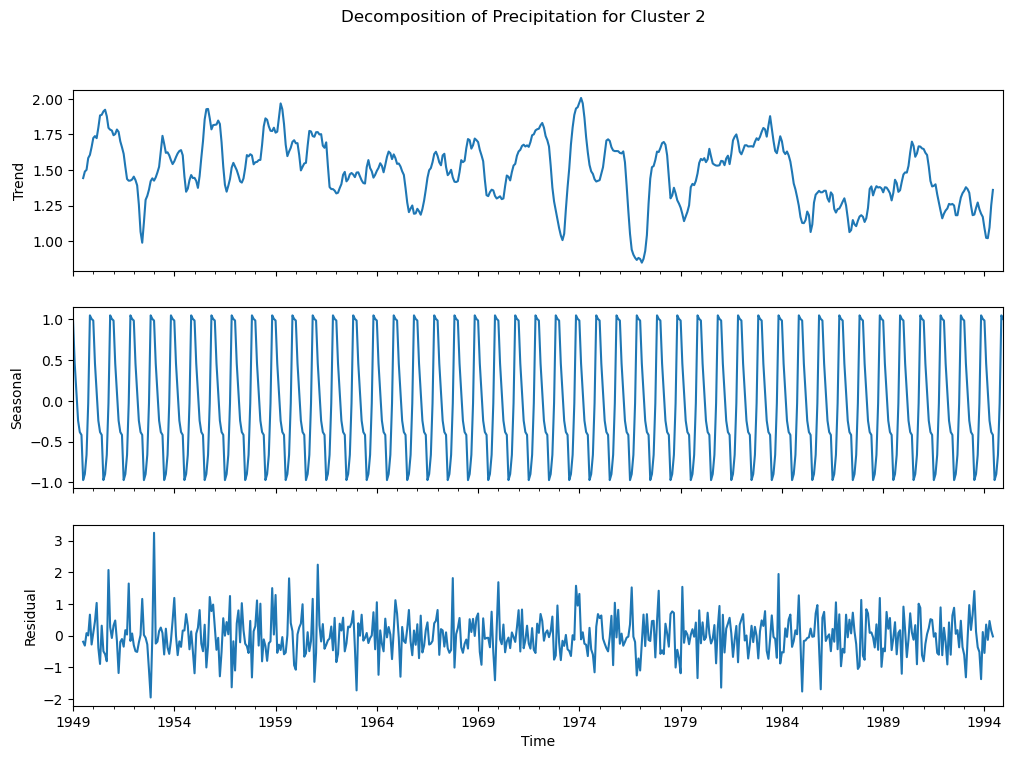

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_clusters = df_flat[['precipitation', 'location_cluster', 'time']]

for cluster_label, cluster_data in df_clusters.groupby('location_cluster'):
    # Resample to ensure there is data for every month
    cluster_data_resampled = cluster_data.set_index('time').resample('M').mean().fillna(0)
    
    # Decompose the resampled time series
    decomposition = seasonal_decompose(cluster_data_resampled['precipitation'], model='additive')
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot the decomposed components
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    trend.plot(ax=ax1, legend=False)
    ax1.set_ylabel('Trend')
    seasonal.plot(ax=ax2, legend=False)
    ax2.set_ylabel('Seasonal')
    residual.plot(ax=ax3, legend=False)
    ax3.set_ylabel('Residual')
    
    # Add titles, labels, etc.
    plt.suptitle(f"Decomposition of Precipitation for Cluster {cluster_label}")
    plt.xlabel('Time')
    plt.show()


### Multiplicative Decomposition

multiplicative seasonal decomposition cannot handle zero or negative values
- some precipitation can be 0

C:\Users\User\AppData\Local\Temp\ipykernel_32916\2375198608.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['precipitation'] += 0.01


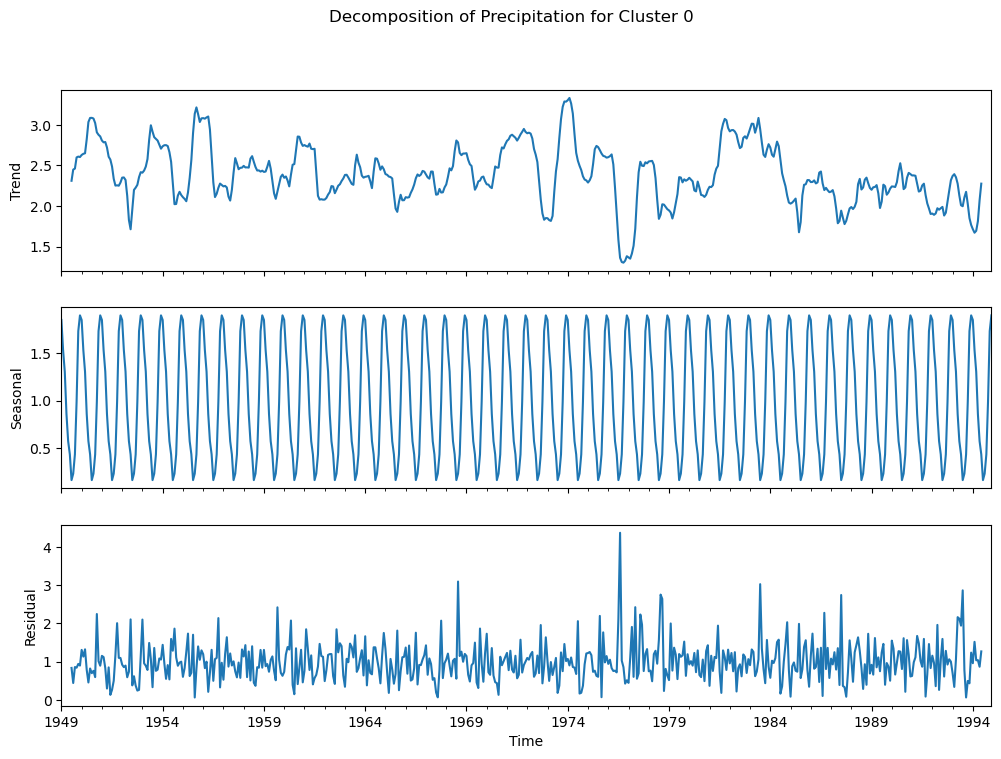

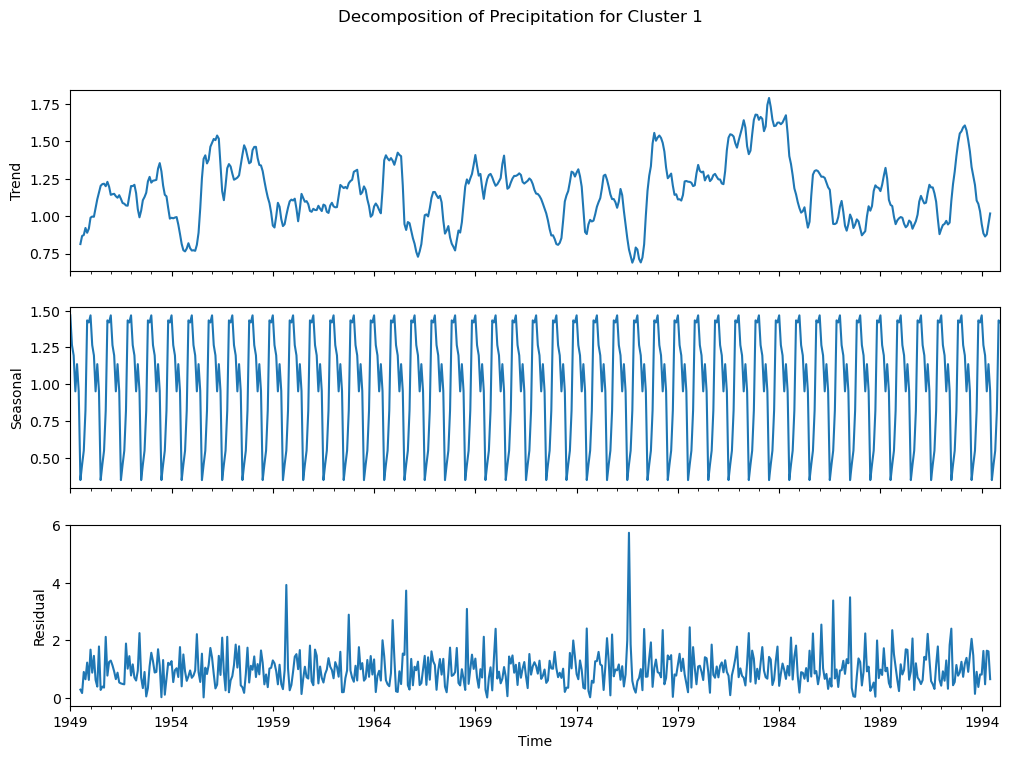

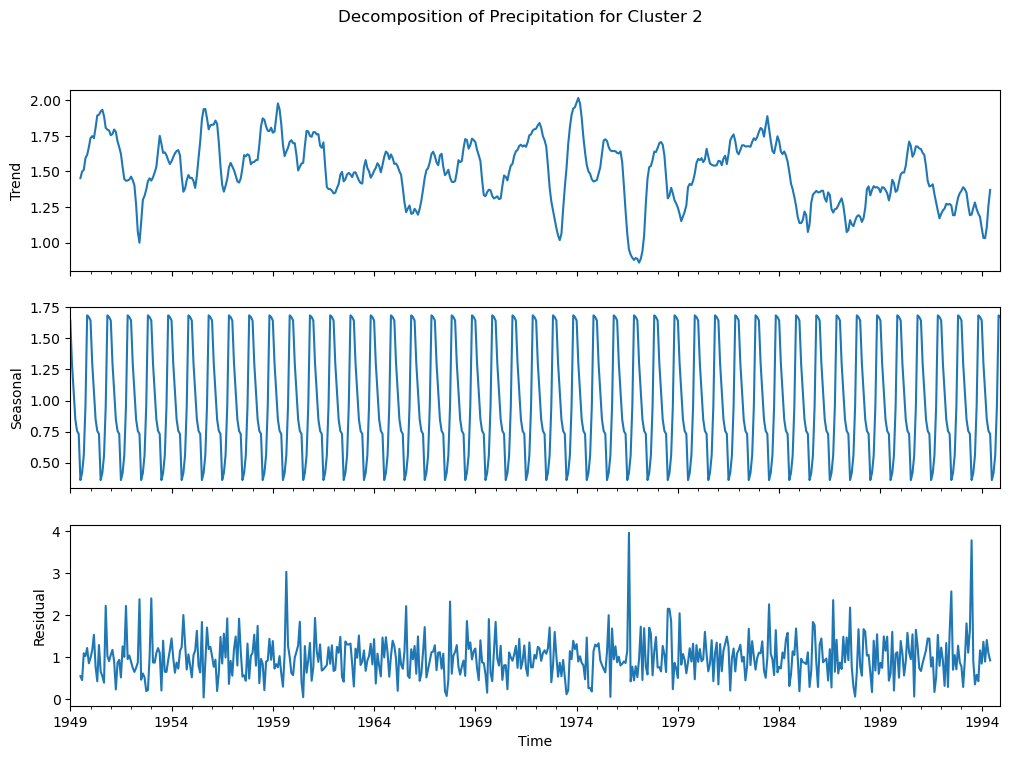

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_clusters = df_flat[['precipitation', 'location_cluster', 'time']]

df_clusters['precipitation'] += 0.01

for cluster_label, cluster_data in df_clusters.groupby('location_cluster'):
    # Resample to ensure there is data for every month
    cluster_data_resampled = cluster_data.set_index('time').resample('M').mean().fillna(0)
    
    # Decompose the resampled time series
    decomposition = seasonal_decompose(cluster_data_resampled['precipitation'], model='multiplicative')
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot the decomposed components
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    trend.plot(ax=ax1, legend=False)
    ax1.set_ylabel('Trend')
    seasonal.plot(ax=ax2, legend=False)
    ax2.set_ylabel('Seasonal')
    residual.plot(ax=ax3, legend=False)
    ax3.set_ylabel('Residual')
    
    # Add titles, labels, etc.
    plt.suptitle(f"Decomposition of Precipitation for Cluster {cluster_label}")
    plt.xlabel('Time')
    plt.show()

### Augmented Dickey-Fuller test (Stationary test)

In [87]:
from statsmodels.tsa.stattools import adfuller

# Group by location_cluster and month, calculate the mean precipitation
monthly_avg_precipitation = df_flat.groupby(['location_cluster', df_flat['time'].dt.month])['precipitation'].mean().reset_index()

for cluster_label, cluster_data in monthly_avg_precipitation.groupby('location_cluster'):
    result = adfuller(cluster_data['precipitation'])
    
    print(f"Cluster {cluster_label}:")
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    print()

Cluster 0:
ADF Statistic: -2.4626259106755795
p-value: 0.12483462742410456
Critical Values:
   1%: -4.331573
   5%: -3.23295
   10%: -2.7487

Cluster 1:
ADF Statistic: -3.367760391248225
p-value: 0.012108261920798282
Critical Values:
   1%: -4.9386902332361515
   5%: -3.477582857142857
   10%: -2.8438679591836733

Cluster 2:
ADF Statistic: -1.9496500376645447
p-value: 0.30907640855153284
Critical Values:
   1%: -4.331573
   5%: -3.23295
   10%: -2.7487



### ACF & PACF

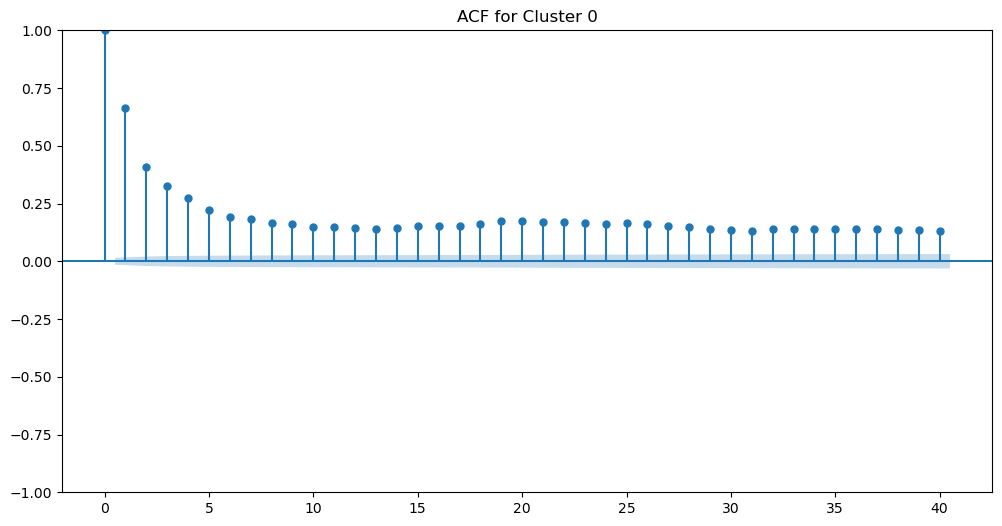

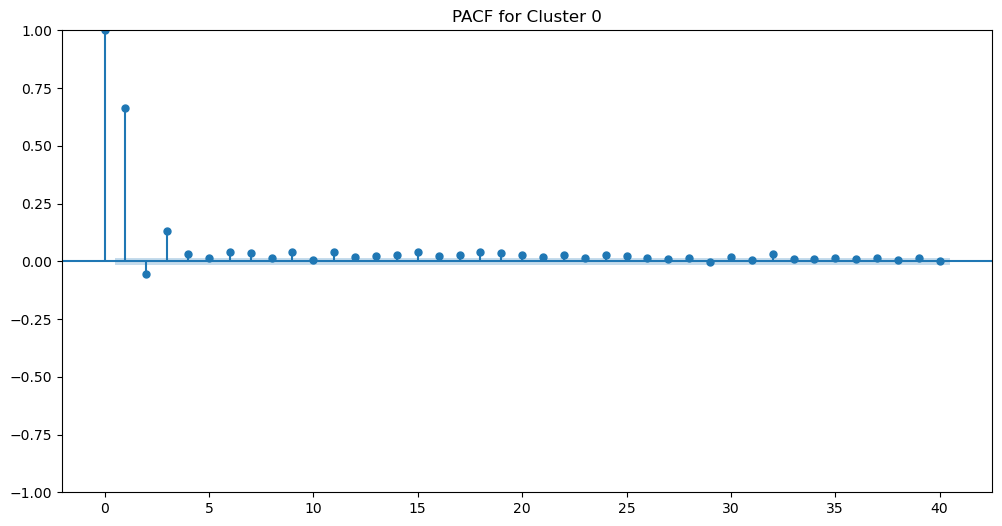

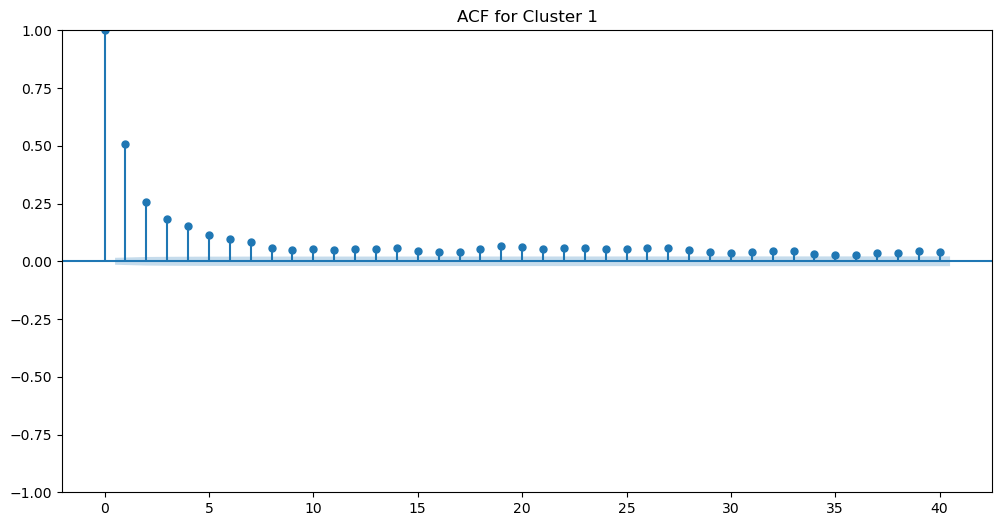

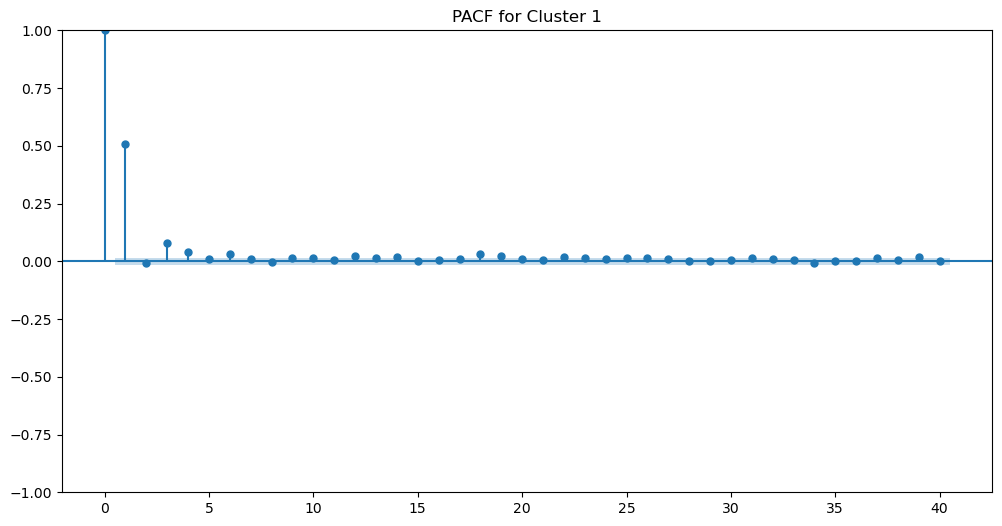

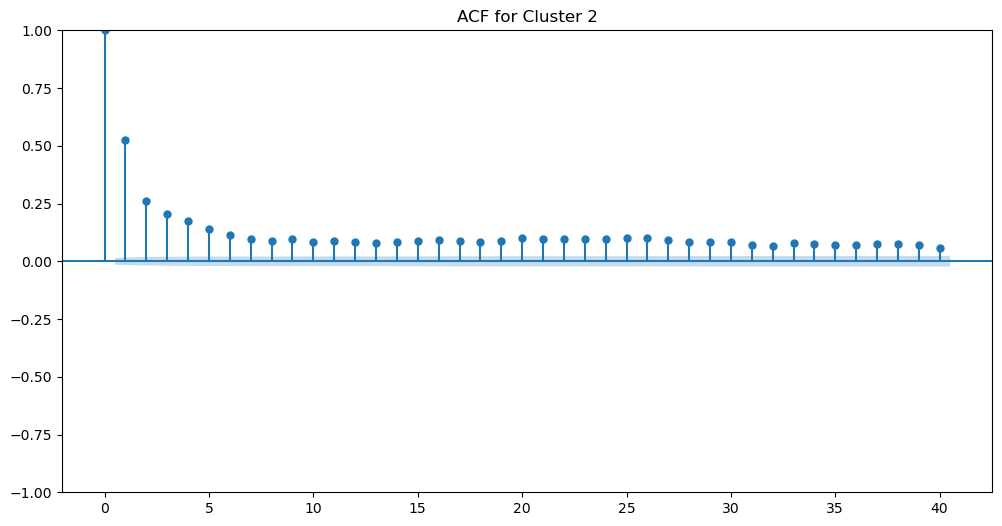

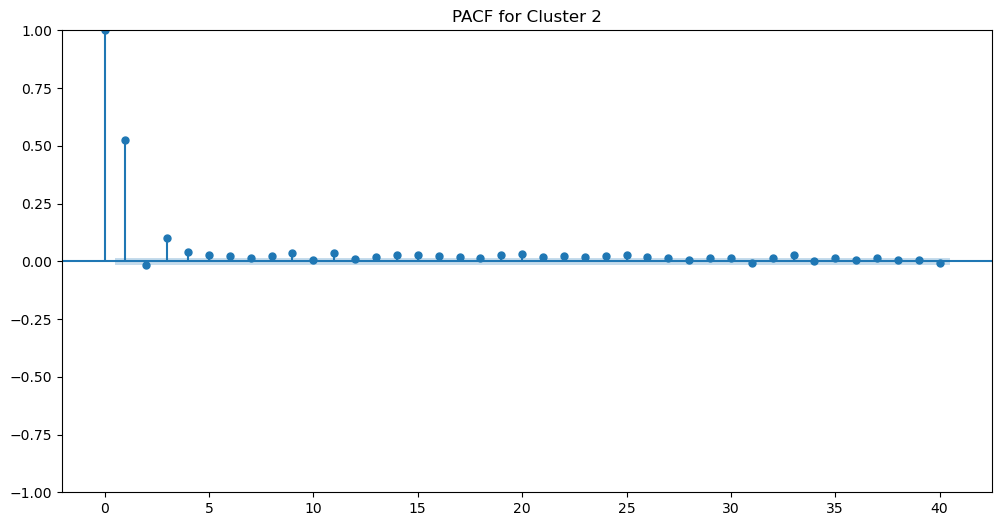

In [91]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df_clusters = df_flat[['precipitation', 'location_cluster', 'time']]

df_clusters = df_clusters.groupby(['time', 'location_cluster']).agg({'precipitation': 'mean'}).reset_index()

for cluster_label, cluster_data in df_clusters.groupby('location_cluster'):
    # Plot ACF
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_acf(cluster_data['precipitation'], lags=40, ax=ax)
    ax.set_title(f'ACF for Cluster {cluster_label}')
    plt.show()

    # Plot PACF
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_pacf(cluster_data['precipitation'], lags=40, ax=ax)
    ax.set_title(f'PACF for Cluster {cluster_label}')
    plt.show()

Corr heatmap

C:\Users\User\AppData\Local\Temp\ipykernel_25368\1076382932.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_flat.corr()


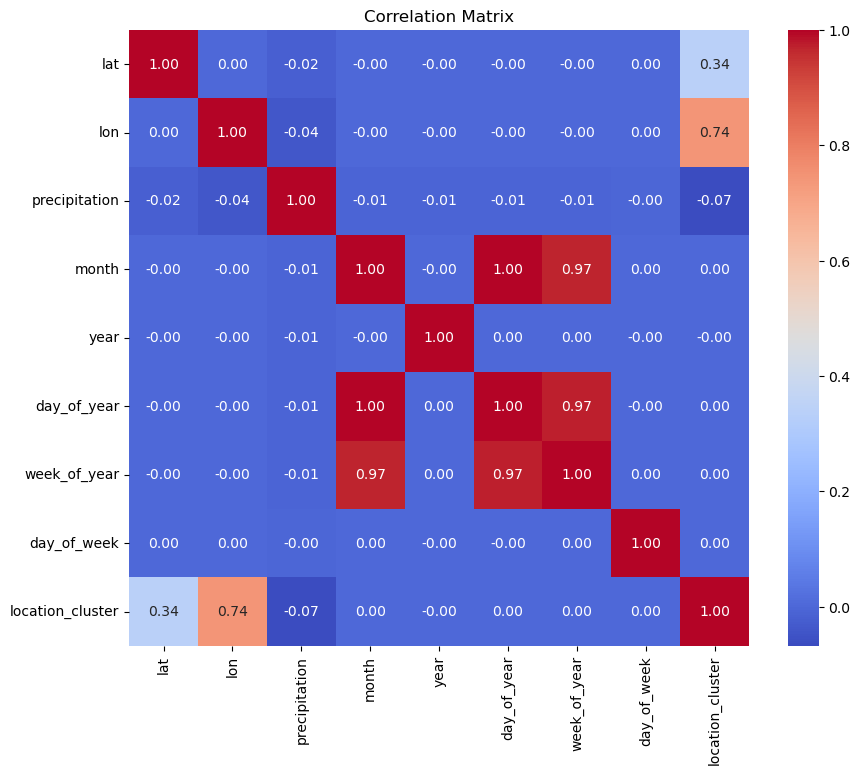

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_flat.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

# Training Models

### Linear Regression 

In [142]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [148]:
def evaluate_model(y_test, y_pred):
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    print("MSE:", mse)

    # Calculate Root Mean Squared Error
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    print("MAE:", mae)

    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)
    print("R-squared:", r2)

In [125]:
# Function to plot learning curves
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error'
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, test_scores_mean, label='Validation error')
    plt.xlabel('Training')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

In [167]:
df_clusters_linear = df_flat[['precipitation', 'location_cluster', 'month', 'year', 'day_of_year', 'week_of_year', 'day_of_week']]

In [168]:
df_clusters_linear

,precipitation,location_cluster,month,year,day_of_year,week_of_year,day_of_week
0,0.000000,0,1,1949,1,53,5
1,0.000000,0,1,1949,1,53,5
2,0.000000,0,1,1949,1,53,5
3,0.000000,0,1,1949,1,53,5
4,0.000000,0,1,1949,1,53,5
...,...,...,...,...,...,...,...
4569867,23.900000,1,12,1994,365,52,5
4569868,25.800001,1,12,1994,365,52,5
4569869,7.400000,1,12,1994,365,52,5
4569870,0.000000,1,12,1994,365,52,5


In [154]:
X = df_clusters_linear[['location_cluster', 'month', 'year', 'day_of_year', 'week_of_year', 'day_of_week']]
y = df_clusters_linear['precipitation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Get coefficients
coefficients = linear_model.coef_
feature_names = X.columns

# feature importance
for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef}')

location_cluster: -0.4886342411688384
month: -0.15378122549777595
year: -0.0036396300960102822
day_of_year: 0.0036963026567088594
week_of_year: 0.0063190744269982285
day_of_week: -0.013045505310256975


In [155]:
y_pred = linear_model.predict(X_test)

evaluate_model(y_pred, y_test)

MSE: 34.75568064480335
RMSE: 5.895394867589731
MAE: 2.7474961495443857
R-squared: -203.00937270732692


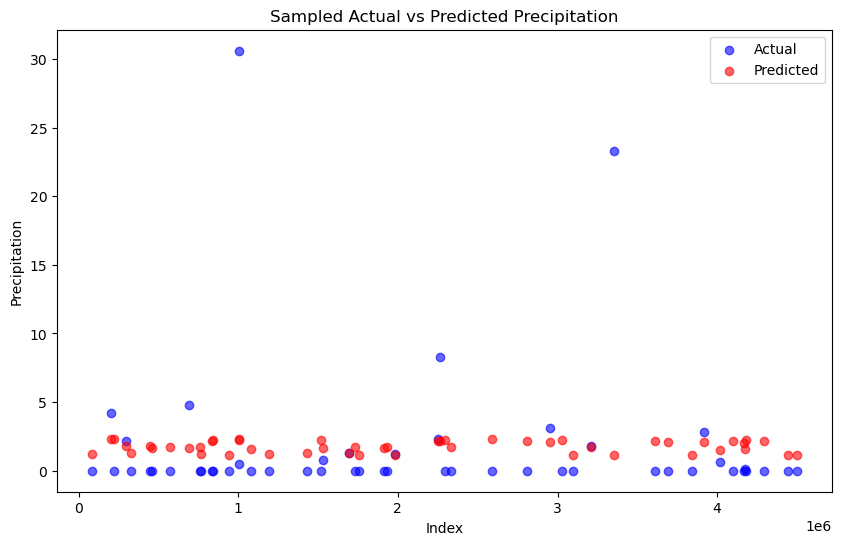

In [165]:
sample_size = 50

# Sample the indices from y_pred
sample_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
y_test_sampled = y_test.iloc[sample_indices]
y_pred_sampled = y_pred[sample_indices]
residuals_sampled = y_pred_sampled - y_test_sampled

# Plot the sampled actual values and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_sampled.index, y_test_sampled, color='blue', label='Actual', alpha=0.6)
plt.scatter(y_test_sampled.index, y_pred_sampled, color='red', label='Predicted', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Precipitation')
plt.title('Sampled Actual vs Predicted Precipitation')
plt.legend()
plt.show()

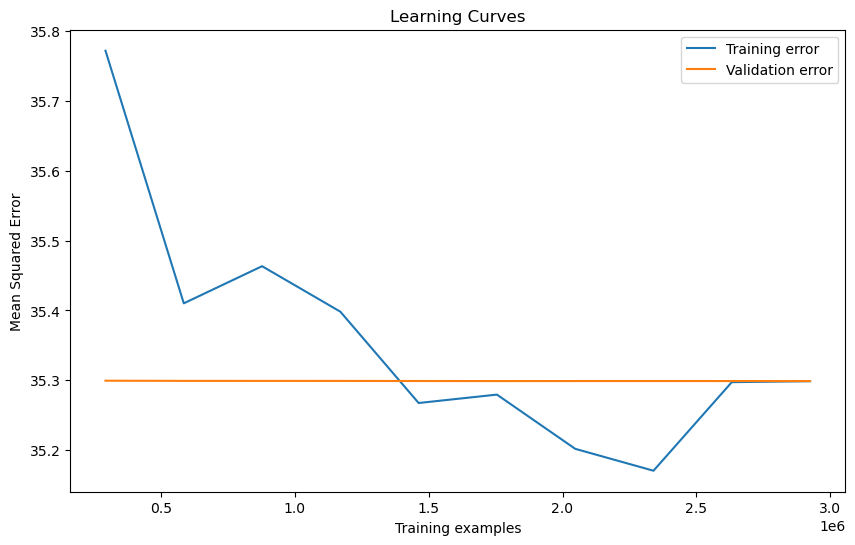

In [193]:
plot_learning_curves(linear_model, X_train, y_train)

Random Forest

In [126]:
from sklearn.ensemble import RandomForestRegressor

In [133]:
df_clusters_rf = df_flat[['precipitation', 'location_cluster', 'month']]

In [134]:
df_clusters_rf

,precipitation,location_cluster,month
0,0.000000,0,1
1,0.000000,0,1
2,0.000000,0,1
3,0.000000,0,1
4,0.000000,0,1
...,...,...,...
4569867,23.900000,1,12
4569868,25.800001,1,12
4569869,7.400000,1,12
4569870,0.000000,1,12


In [135]:
# Prepare features and target
X = df_clusters_rf[['location_cluster', 'month']]
y = df_clusters_rf['precipitation']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [136]:
X_train['month'] = X_train['month'].astype('category')
X_train['location_cluster'] = X_train['location_cluster'].astype('category')

In [137]:
from sklearn.pipeline import make_pipeline

In [144]:
forest = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)

pipeline = make_pipeline(forest)

In [145]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(max_depth=20, random_state=42))])

In [149]:
# Evaluate the model
y_pred = pipeline.predict(X_test)
evaluate_model(y_test, y_pred)

MSE: 33.505537079214434
RMSE: 5.788396762421736
MAE: 2.6369536413673096
R-squared: 0.04080333930873026


## Time Series

In [184]:
from sklearn.model_selection import TimeSeriesSplit

In [205]:
def evaluate_time_series(test, forecast, model):
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    r2 = r2_score(test, forecast)

    # print(f"{model}: RMSE = {rmse}, MAE = {mae}, R-squared = {r2}")

    return rmse, mae, r2

ARIMA

In [196]:
df_clusters_ARIMA = df_flat[['precipitation', 'location_cluster', 'time']]

In [197]:
# Group by 'time' and 'location_cluster' and aggregate precipitation using mean
df_clusters_ARIMA = df_clusters_ARIMA.groupby(['time', 'location_cluster']).agg({'precipitation': 'mean'}).reset_index()

In [209]:
df_clusters_ARIMA = pd.merge(df_clusters_ARIMA, df_flat[['location_cluster', 'time', 'month', 'year', 'day_of_year', 'week_of_year', 'day_of_week']].drop_duplicates(), on=['time', 'location_cluster'], how='inner')

In [200]:
df_clusters_ARIMA['time'] = pd.to_datetime(df_clusters_ARIMA['time'])

In [203]:
df_clusters_ARIMA

,time,location_cluster,precipitation,month,year,day_of_year,week_of_year,day_of_week
0,1949-01-01,0,8.928696,1,1949,1,53,5
1,1949-01-01,1,3.233333,1,1949,1,53,5
2,1949-01-01,2,2.781579,1,1949,1,53,5
3,1949-01-02,0,2.046957,1,1949,2,53,6
4,1949-01-02,1,0.650617,1,1949,2,53,6
...,...,...,...,...,...,...,...,...
50398,1994-12-30,1,0.000000,12,1994,364,52,4
50399,1994-12-30,2,0.000000,12,1994,364,52,4
50400,1994-12-31,0,0.024348,12,1994,365,52,5
50401,1994-12-31,1,1.743210,12,1994,365,52,5


In [210]:
from statsmodels.tsa.arima.model import ARIMA

for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    tscv = TimeSeriesSplit(n_splits=5)
    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []

    cluster_data.set_index('time', inplace=True)
    cluster_data.index.freq = 'D'

    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        # Fit ARIMA model
        order = (5, 1, 0)
        model = ARIMA(train['precipitation'], order=order)
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test['precipitation'], forecast, f"ARIMA{order}")

        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

    avg_rmse = np.mean(avg_rmse_values)
    avg_mae = np.mean(avg_mae_values)
    avg_r2 = np.mean(avg_r2_values)

    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse}, Average MAE = {avg_mae}, Average R-squared = {avg_r2} \n")

Cluster 0: Average RMSE = 3.8845043868519396, Average MAE = 2.5007931785743542, Average R-squared = -0.13855755410768125 

Cluster 1: Average RMSE = 2.3483966030038244, Average MAE = 1.6407138433026731, Average R-squared = -0.3659808374602076 

Cluster 2: Average RMSE = 2.448123204570838, Average MAE = 1.5670542099902243, Average R-squared = -0.1279315762160306 



SARIMA

Training + Evaluation

In [211]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    tscv = TimeSeriesSplit(n_splits=5)
    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []

    cluster_data.set_index('time', inplace=True)
    cluster_data.index.freq = 'D'

    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        # Fit SARIMA model
        order = (5, 1, 0)
        seasonal_order = (0, 0, 0, 0)
        model = SARIMAX(train['precipitation'], order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test['precipitation'], forecast, f"SARIMA{order}")

        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

    avg_rmse = np.mean(avg_rmse_values)
    avg_mae = np.mean(avg_mae_values)
    avg_r2 = np.mean(avg_r2_values)

    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse}, Average MAE = {avg_mae}, Average R-squared = {avg_r2} \n")

Cluster 0: Average RMSE = 3.8845043868519396, Average MAE = 2.5007931785743542, Average R-squared = -0.13855755410768125 

Cluster 1: Average RMSE = 2.3483966030038244, Average MAE = 1.6407138433026731, Average R-squared = -0.3659808374602076 

Cluster 2: Average RMSE = 2.448123204570838, Average MAE = 1.5670542099902243, Average R-squared = -0.1279315762160306 



Hyperparameters Tuning SARIMA

In [218]:
# Group by 'time' and 'location_cluster' and aggregate precipitation using mean
df_clusters_ARIMA = df_clusters_ARIMA.groupby(['time', 'location_cluster']).agg({'precipitation': 'mean'}).reset_index()

In [ ]:
start_date = pd.to_datetime('1949-01-01')
end_date = pd.to_datetime('1969-01-01')

# Subset the data for tuning
df_clusters_ARIMA_subset = df_clusters_ARIMA[(df_clusters_ARIMA['time'] >= start_date) & (df_clusters_ARIMA['time'] < end_date)]

In [219]:
df_clusters_ARIMA

,time,location_cluster,precipitation
0,1949-01-01,0,8.928696
1,1949-01-01,1,3.233333
2,1949-01-01,2,2.781579
3,1949-01-02,0,2.046957
4,1949-01-02,1,0.650617
...,...,...,...
50398,1994-12-30,1,0.000000
50399,1994-12-30,2,0.000000
50400,1994-12-31,0,0.024348
50401,1994-12-31,1,1.743210


In [225]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the ranges for the parameters
p = d = q = range(0, 3)  # AR, I, MA
P = D = Q = range(0, 2)  # Seasonal AR, I, MA
s = 4  # Seasonal period (quarterly seasonality)

# Create a list of all parameter combinations
param_combinations = list(itertools.product(p, d, q, P, D, Q))

for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    # cluster_data.set_index('time', inplace=True)
    # cluster_data.index.freq = 'D'

    # best_aic = float("inf")
    # best_order = None
    # best_seasonal_order = None

    # for param in param_combinations:
    #     # Unpack the seasonal order
    #     seasonal_order = param[3:6]  # (P, D, Q)

    #     # Fit SARIMA model
    #     model = SARIMAX(cluster_data['precipitation'], order=param[:3], seasonal_order=seasonal_order + (s,))
    #     model_fit = model.fit()

    #     # Calculate AIC (Akaike Information Criterion)
    #     aic = model_fit.aic

    #     # Update best parameters if current model has lower AIC
    #     if aic < best_aic:
    #         best_aic = aic
    #         best_order = param[:3]
    #         best_seasonal_order = seasonal_order

    # print(f"Cluster {cluster_label}:")
    # print("  Best SARIMA order:", best_order)
    # print("  Best SARIMA seasonal order:", best_seasonal_order)

0
1
2


Cluster 0:
  Best SARIMA order: (2, 0, 2)
  Best SARIMA seasonal order: (1, 1, 1, 4)